In [1]:
import torch
import matplotlib.pyplot as plt

#lower confidence yields more, but less accurate predictions
CONFIDENCE=0.5

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

def visualize_predictions(image, outputs, threshold=CONFIDENCE):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold
  
  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)

In [2]:
# Annotate a saved video every other second
import cv2
from tqdm.notebook import tqdm
import time
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random
from IPython.display import Video
from yolo_model import YoloS
from transformers import AutoFeatureExtractor
from PIL import ImageDraw


torch.cuda.empty_cache()
experiment_name = 'yolo-tiny-deer-non-deer'
device = 'cpu'

# Load the model
model = YoloS.load_from_checkpoint(f"checkpoints/{experiment_name}.ckpt", num_labels=2)
feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small")
model.eval()
model.to(device)

Some weights of YolosForObjectDetection were not initialized from the model checkpoint at hustvl/yolos-tiny and are newly initialized because the shapes did not match:
- class_labels_classifier.layers.2.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([3]) in the model instantiated
- class_labels_classifier.layers.2.weight: found shape torch.Size([92, 192]) in the checkpoint and torch.Size([3, 192]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\William.White\AppData\Local\miniconda3\envs\lender_approval\lib\site-packages\transformers\models\yolos\feature_extraction_yolos.py:28: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


YoloS(
  (model): YolosForObjectDetection(
    (vit): YolosModel(
      (embeddings): YolosEmbeddings(
        (patch_embeddings): YolosPatchEmbeddings(
          (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (interpolation): InterpolateInitialPositionEmbeddings()
      )
      (encoder): YolosEncoder(
        (layer): ModuleList(
          (0-11): 12 x YolosLayer(
            (attention): YolosAttention(
              (attention): YolosSelfAttention(
                (query): Linear(in_features=192, out_features=192, bias=True)
                (key): Linear(in_features=192, out_features=192, bias=True)
                (value): Linear(in_features=192, out_features=192, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): YolosSelfOutput(
                (dense): Linear(in_features=192, out_features=192, bias=True)
                (dropout): Drop

In [26]:
from PIL import ImageFont
font = 'arial.ttf'

test_video_folder = '../test_videos'
video_filenames = [path for path in os.listdir(test_video_folder) if path.endswith('.mp4')]
video_to_show_index = 2
video_path = os.path.join(test_video_folder, video_filenames[video_to_show_index])
threshold = 0.5


# Load the video
cap = cv2.VideoCapture(video_path)
fps = round(cap.get(cv2.CAP_PROP_FPS))
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"FPS: {fps}")
print(f"Frame count: {frame_count}")

# Create the output video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
output_video_path = 'output.mp4'
out = cv2.VideoWriter(output_video_path, fourcc, fps, (int(cap.get(3)), int(cap.get(4))))
bboxes_scaled = []

id2label = {0: 'deer', 1: 'non-deer'}
identified = False

tested_font = ImageFont.truetype(font, 30)

# Annotate the video
for frame_idx in tqdm(range(frame_count)):
    ret, frame = cap.read()
    if frame_idx == 0:
        print(f"Frame shape: {frame.shape}")
    if ret:
        # # Convert the frame to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Convert the frame to a PIL image
        image = Image.fromarray(frame_rgb)

        # Annotate every other second
        if frame_idx % round(fps * 0.5) == 0:
            print(f"Annotating frame {frame_idx}")
            # Convert the frame to a torch tensor
            preprocessed_image = feature_extractor(images=image, return_tensors="pt")

            image_tensor = preprocessed_image['pixel_values'].squeeze().unsqueeze(0).to(device)
            # Get the model predictions
            outputs = model(pixel_values=image_tensor)

            # Get the predictions
            probas = outputs.logits.softmax(-1)[0, :, :-1]
            keep = probas.max(-1).values > threshold

            bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), frame_rgb.shape[:2][::-1])
            identified = True
            del image_tensor
        # Draw the predictions
        draw = ImageDraw.Draw(image)
        colors = COLORS * 100
        for p, (xmin, ymin, xmax, ymax), c in zip(probas[keep], bboxes_scaled.tolist(), colors):
            cl = p.argmax()
            text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
            draw.rectangle([(xmin, ymin), (xmax, ymax)], outline=(255, 0, 0), width=3)
            # Write large text
            draw.text((xmin, ymin), text, fill=(255, 0, 0), font=tested_font)
        # Convert the frame back to a numpy array
        image = np.array(image)
        # Convert the frame back to BGR
        frame = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        # Write the frame to the output video
        out.write(frame)
    else:
        break

# Release the video capture and writer
cap.release()
out.release()

# Upload the output video to wandb
wandb.save(output_video_path)

FPS: 30
Frame count: 458


  0%|          | 0/458 [00:00<?, ?it/s]

Frame shape: (720, 1280, 3)
Annotating frame 0
Annotating frame 15
Annotating frame 30
Annotating frame 45
Annotating frame 60
Annotating frame 75
Annotating frame 90
Annotating frame 105
Annotating frame 120
Annotating frame 135
Annotating frame 150
Annotating frame 165
Annotating frame 180
Annotating frame 195
Annotating frame 210
Annotating frame 225
Annotating frame 240
Annotating frame 255
Annotating frame 270
Annotating frame 285
Annotating frame 300
Annotating frame 315
Annotating frame 330
Annotating frame 345
Annotating frame 360
Annotating frame 375
Annotating frame 390
Annotating frame 405
Annotating frame 420
Annotating frame 435
Annotating frame 450


NameError: name 'wandb' is not defined

In [ ]:
del preprocessed_image

In [6]:
torch.cuda.empty_cache()

In [4]:
preprocessed_image_2 == preprocessed_image_1

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [17]:
import torchvision
import os
from transformers import AutoFeatureExtractor
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from transformers import DetrConfig, AutoModelForObjectDetection
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, feature_extractor, set):
        ann_file = os.path.join(img_folder, f"coco_{set}.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.feature_extractor = feature_extractor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        img, target = super().__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        # encoding = self.feature_extractor(images=img, annotations=target, return_tensors="pt")
        # pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        # target = encoding["labels"][0] # remove batch dimension

        return img


feature_extractor = AutoFeatureExtractor.from_pretrained("hustvl/yolos-small", size=512, max_size=864)
data_folder = 'training_data'
test_dataset = CocoDetection(img_folder=data_folder, feature_extractor=feature_extractor, set='test')

print("Number of testing examples:", len(test_dataset))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Number of testing examples: 4923


c:\Users\William.White\AppData\Local\miniconda3\envs\lender_approval\lib\site-packages\transformers\models\yolos\feature_extraction_yolos.py:28: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(


In [39]:
bboxes_scaled

tensor([[217.0335, 238.4433, 578.1036, 924.0955],
        [215.9619, 236.6817, 575.6082, 918.9088]], grad_fn=<MulBackward0>)

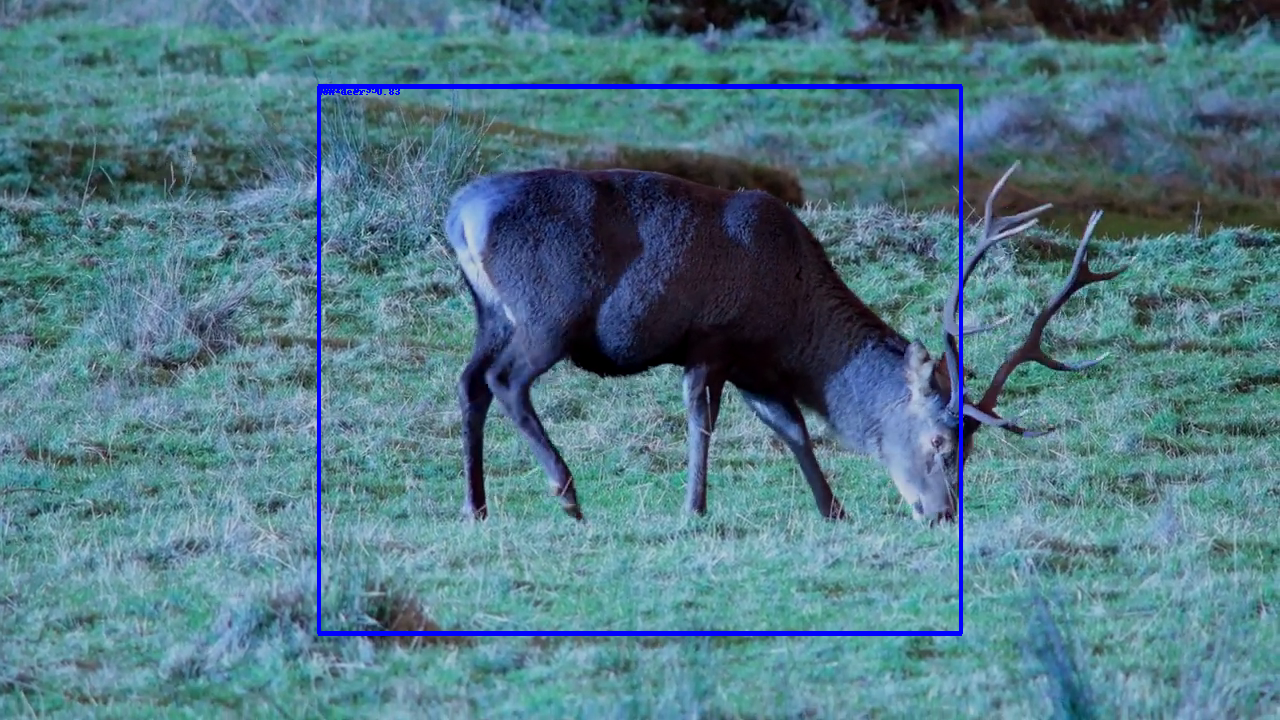

In [7]:
image = Image.fromarray(frame)
image

In [28]:
frame.shape

(720, 1280, 3)

In [16]:
outputs

YolosObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[-1.0791, -0.4138,  3.6985],
         [-0.8355,  0.0661,  3.7664],
         [-0.5125, -0.0409,  3.5339],
         [ 0.1090, -0.5056,  4.0364],
         [ 0.3739, -0.4918,  3.7594],
         [-0.5131, -1.5547,  4.6357],
         [-1.0689, -0.1075,  3.8760],
         [ 0.5870, -0.6895,  3.5071],
         [ 1.0857, -1.6001,  4.9691],
         [ 0.0486, -0.5585,  3.4260],
         [-0.0515, -0.3234,  3.4942],
         [ 0.2556, -0.6634,  3.6021],
         [-0.5192, -0.2880,  3.5346],
         [ 0.2359, -1.6486,  4.4048],
         [-0.5066, -0.1078,  3.8856],
         [-0.5301, -0.0104,  3.5198],
         [ 5.3474, -2.9710,  1.0285],
         [-0.9859, -0.3555,  3.7080],
         [ 0.3738, -0.5504,  3.7273],
         [-0.1003, -0.3603,  3.2414],
         [-1.1812, -0.5490,  3.7673],
         [-0.4178, -0.3572,  3.4288],
         [ 0.6055, -1.0213,  3.6520],
         [ 0.9062, -1.2071,  5.0916],
         [-0.2967, -0.4504,

In [30]:
image_tensor.size()[2:]

torch.Size([486, 864])